In [ ]:
!pip install torch torchvision matplotlib opencv-python timm tqdm requests

In [ ]:
import os
import shutil
import requests
import zipfile
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torchvision import transforms, datasets
from tqdm import tqdm
import timm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

drive_dir = """/content/drive/MyDrive/KoreaUniv/2024/DEEP_LEARNING/Final_Project"""

Mounted at /content/drive


In [ ]:
data_dir = drive_dir + "/datasets/Office-31/domain_adaptation_images"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
print(data_dir + '/amazon/images')
!ls -l {target_dir}

In [ ]:
batch_size = 32
learning_rate = 1e-4
num_epochs = 20

In [ ]:
source_dir = data_dir + '/amazon/images'
target_dir = data_dir + '/webcam/images'

source_dataset = datasets.ImageFolder(root=source_dir, transform=transform)
target_dataset = datasets.ImageFolder(root=target_dir, transform=transform)

source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)

Visualizing Amazon (Source Domain) Samples...


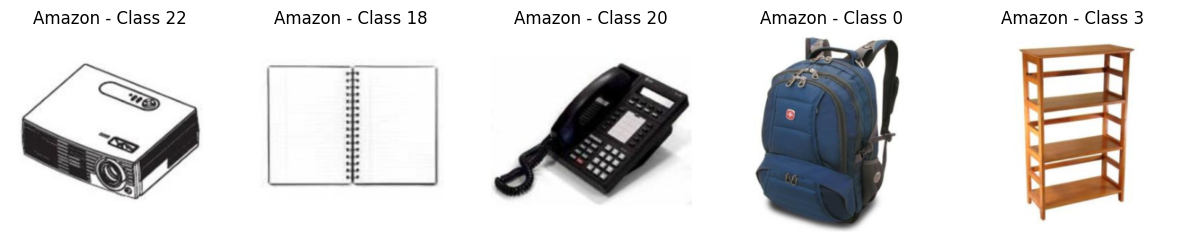

Visualizing Webcam (Target Domain) Samples...


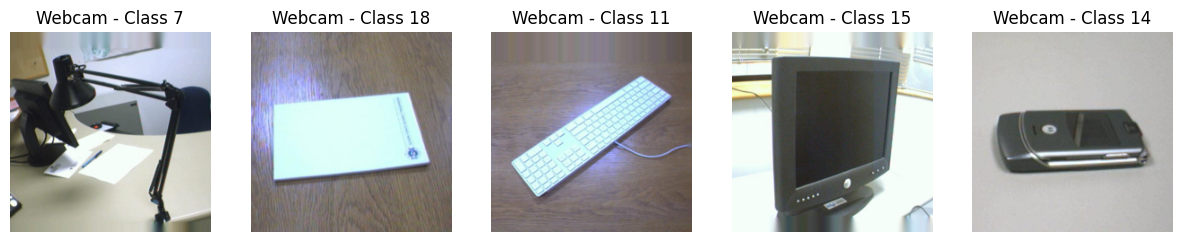

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img / 2 + 0.5  # 정규화 해제!!
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

def visualize_samples(dataloader, domain_name, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 5))
    for idx in range(num_images):
        plt.subplot(1, num_images, idx+1)
        imshow(images[idx], title=f"{domain_name} - Class {labels[idx]}")
    plt.show()

print("Visualizing Amazon (Source Domain) Samples...")
visualize_samples(source_loader, domain_name="Amazon")

print("Visualizing Webcam (Target Domain) Samples...")
visualize_samples(target_loader, domain_name="Webcam")

In [ ]:
class ViTDomainAdaptation(nn.Module):
    def __init__(self, num_classes):
        super(ViTDomainAdaptation, self).__init__()
        self.feature_extractor = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x)
        outputs = self.fc(features)
        return features, outputs

In [ ]:
model = ViTDomainAdaptation(num_classes=len(source_dataset.classes)).to(device)

In [ ]:
def coral_loss(source, target):
    d = source.size(1)
    source_cov = torch.mm(source.T, source) / source.size(0)
    target_cov = torch.mm(target.T, target) / target.size(0)
    loss = torch.norm(source_cov - target_cov, p="fro") ** 2 / (4 * d * d)
    return loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
classification_loss = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(num_epochs):
    model.train()
    total_loss, total_class_loss, total_coral_loss = 0, 0, 0

    source_iter = iter(source_loader)
    target_iter = iter(target_loader)

    for _ in tqdm(range(min(len(source_loader), len(target_loader)))):
        source_data, source_labels = next(source_iter)
        target_data, _ = next(target_iter)

        source_data, source_labels = source_data.to(device), source_labels.to(device)
        target_data = target_data.to(device)

        source_features, source_preds = model(source_data)
        target_features, _ = model(target_data)

        class_loss = classification_loss(source_preds, source_labels)
        domain_loss = coral_loss(source_features, target_features)

        # Trade-off parameter
        loss = class_loss + 0.1 * domain_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_coral_loss += domain_loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss:.4f}, Class Loss: {total_class_loss:.4f}, Coral Loss: {total_coral_loss:.4f}")

100%|██████████| 25/25 [17:39<00:00, 42.39s/it]


Epoch [1/20], Total Loss: 38.8962, Class Loss: 38.4528, Coral Loss: 4.4339


100%|██████████| 25/25 [06:40<00:00, 16.03s/it]


Epoch [2/20], Total Loss: 14.7636, Class Loss: 14.2777, Coral Loss: 4.8593


100%|██████████| 25/25 [04:56<00:00, 11.88s/it]


Epoch [3/20], Total Loss: 9.6480, Class Loss: 9.2105, Coral Loss: 4.3753


100%|██████████| 25/25 [03:53<00:00,  9.33s/it]


Epoch [4/20], Total Loss: 8.5416, Class Loss: 8.1520, Coral Loss: 3.8951


100%|██████████| 25/25 [02:50<00:00,  6.82s/it]


Epoch [5/20], Total Loss: 6.4199, Class Loss: 5.9877, Coral Loss: 4.3224


100%|██████████| 25/25 [02:08<00:00,  5.13s/it]


Epoch [6/20], Total Loss: 6.5325, Class Loss: 6.1645, Coral Loss: 3.6803


100%|██████████| 25/25 [01:23<00:00,  3.32s/it]


Epoch [7/20], Total Loss: 5.2000, Class Loss: 4.8493, Coral Loss: 3.5067


100%|██████████| 25/25 [01:13<00:00,  2.94s/it]


Epoch [8/20], Total Loss: 2.6210, Class Loss: 2.1996, Coral Loss: 4.2138


100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


Epoch [9/20], Total Loss: 3.8871, Class Loss: 3.5497, Coral Loss: 3.3744


100%|██████████| 25/25 [00:44<00:00,  1.76s/it]


Epoch [10/20], Total Loss: 3.0631, Class Loss: 2.7035, Coral Loss: 3.5961


100%|██████████| 25/25 [00:37<00:00,  1.50s/it]


Epoch [11/20], Total Loss: 2.7018, Class Loss: 2.3949, Coral Loss: 3.0693


100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


Epoch [12/20], Total Loss: 3.0265, Class Loss: 2.6883, Coral Loss: 3.3821


100%|██████████| 25/25 [00:28<00:00,  1.12s/it]


Epoch [13/20], Total Loss: 3.0335, Class Loss: 2.7472, Coral Loss: 2.8625


100%|██████████| 25/25 [00:29<00:00,  1.16s/it]


Epoch [14/20], Total Loss: 2.7283, Class Loss: 2.4207, Coral Loss: 3.0754


100%|██████████| 25/25 [00:28<00:00,  1.15s/it]


Epoch [15/20], Total Loss: 1.8755, Class Loss: 1.6036, Coral Loss: 2.7184


100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


Epoch [16/20], Total Loss: 2.4296, Class Loss: 2.1612, Coral Loss: 2.6845


100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


Epoch [17/20], Total Loss: 1.8131, Class Loss: 1.5559, Coral Loss: 2.5725


100%|██████████| 25/25 [00:22<00:00,  1.11it/s]


Epoch [18/20], Total Loss: 1.2236, Class Loss: 0.9355, Coral Loss: 2.8812


100%|██████████| 25/25 [00:20<00:00,  1.21it/s]


Epoch [19/20], Total Loss: 0.8908, Class Loss: 0.6593, Coral Loss: 2.3143


100%|██████████| 25/25 [00:20<00:00,  1.23it/s]

Epoch [20/20], Total Loss: 0.5903, Class Loss: 0.3449, Coral Loss: 2.4536


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for data, labels in target_loader:
        data, labels = data.to(device), labels.to(device)
        _, outputs = model(data)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Accuracy on Webcam domain: {100 * correct / total:.2f}%")

Accuracy on Webcam domain: 72.20%


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

def visualize_predictions(model, dataloader, device, classes, num_images=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 5))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                plt.subplot(1, num_images, images_shown + 1)
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = img / 2 + 0.5
                plt.imshow(img)
                plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
                plt.axis('off')
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.show()

def plot_confusion_matrix(model, dataloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

Visualizing Model Predictions on Webcam Data...


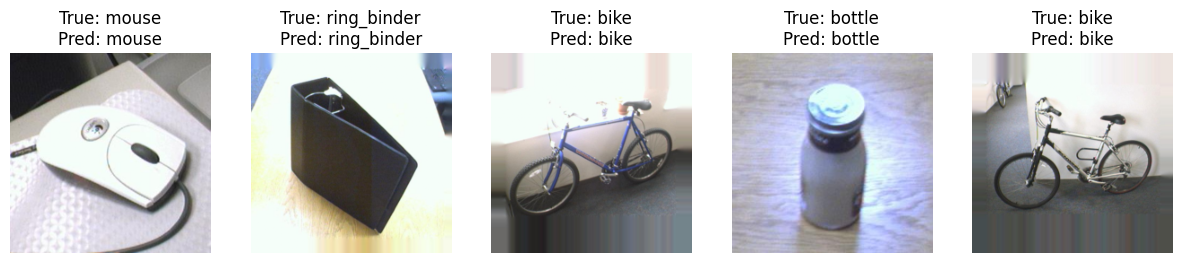

Plotting Confusion Matrix for Webcam Data...


<Figure size 1000x800 with 0 Axes>

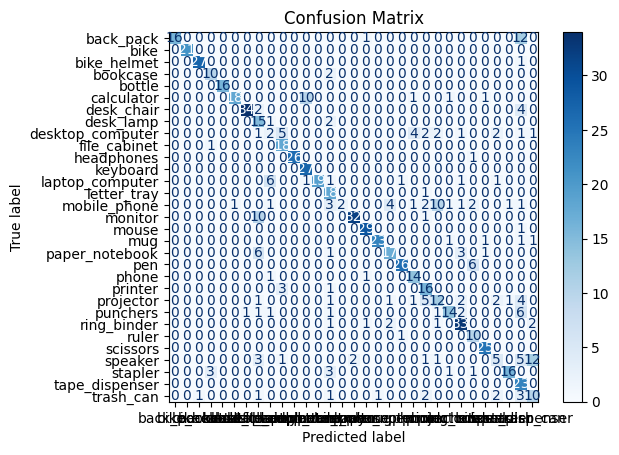

In [ ]:
classes = source_dataset.classes

print("Visualizing Model Predictions on Webcam Data...")
visualize_predictions(model, target_loader, device, classes, num_images=5)

print("Plotting Confusion Matrix for Webcam Data...")
plot_confusion_matrix(model, target_loader, device, classes)